In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Сегментация на основе архитектуры UNet

Обучим UNet сегментировать сгенерированны изображения. 

Минимально скорректированный код взят [отсюда](https://colab.research.google.com/drive/1Fum-Udmayf60qfJAl4N5z8hgUH6_uoTc) (уменьшил разрешение изображений, размер фигур и отступы). 

### Объявим модель UNet и вспомогательные функции

1) DoubleConv - последовательная свертка с одним размером и нормализацией
2) Down - уменьшение размера изображения в два раза
3) Up - увеличение размера изображения в два раза и склейка

Вниз идем через Down, вверх через Up

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
            

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out(x)
        return logits


### Сгенерируем датасеты

Используем одноканальные изображения рамером 48 на 48, на каждом по 3 объекта для сегментации.

In [14]:
from torch.utils.data import DataLoader, TensorDataset
from generate import GrayScaleDataProvider

train_size = 100
val_size = 100

train_X, train_y = GrayScaleDataProvider(48, 48, cnt=3)(train_size)
val_X, val_y = GrayScaleDataProvider(48, 48, cnt=3)(val_size)

train_dataset = TensorDataset(torch.Tensor(train_X), torch.Tensor(train_y))
val_dataset = TensorDataset(torch.Tensor(val_X), torch.Tensor(val_y))

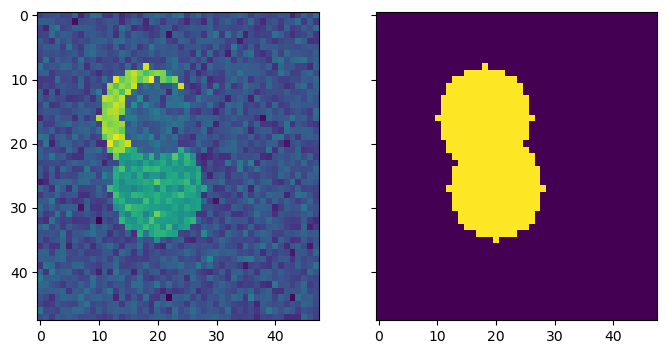

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(train_X[0,...,0], aspect="auto")
ax[1].imshow(train_y[0,...,1], aspect="auto")

### Обучаем модель

Объявим станартную функцию для обучения модели и проведем обучение

In [16]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch import optim

In [17]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            images, true_masks = batch
                
            images = images.permute(0, 3, 1, 2)
            true_masks = true_masks.permute(0, 3, 1, 2)[:, 1:, :, :]

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
 
            masks_pred = model(images)

            if model.n_classes == 1:
                loss = criterion(masks_pred.squeeze(1), true_masks.squeeze(1))
            else:
                loss = criterion(masks_pred, true_masks)

            optimizer.zero_grad(set_to_none=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            
            loss.backward()
            optimizer.step()

            global_step += 1
            epoch_loss += loss.item()
            
        print(f'''Loss: {loss.item()}, Step: {global_step} Epoch: {epoch} ''')

In [18]:
model = UNet(n_channels=1, n_classes=1).to(device)
train_model(model, device, batch_size=8, epochs=5)

Loss: 0.33458051085472107, Step: 13 Epoch: 1 
Loss: 0.283614844083786, Step: 26 Epoch: 2 
Loss: 0.20702843368053436, Step: 39 Epoch: 3 
Loss: 0.14741262793540955, Step: 52 Epoch: 4 
Loss: 0.10440900921821594, Step: 65 Epoch: 5 


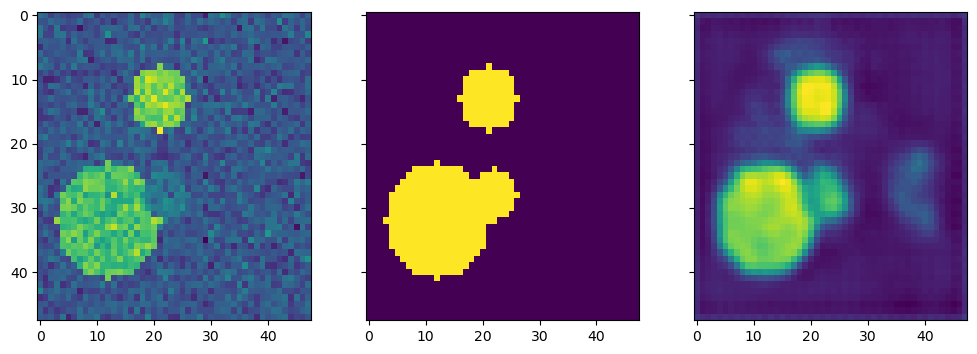

In [19]:
test_X, test_y = val_dataset[0:1]
pred_y = model(test_X.permute(0, 3, 1, 2)).detach().numpy()

fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))

ax[0].imshow(test_X[0,...,0], aspect="auto")
ax[1].imshow(test_y[0,...,1], aspect="auto")
ax[2].imshow(pred_y[0, 0,...], aspect="auto")

### Оценим качество сегментации

Используем BinaryJaccardIndex для вычисления метрики IoU.

In [20]:
from torchmetrics.classification import BinaryJaccardIndex
metric = BinaryJaccardIndex()

val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

iou_scores = []
for images, masks in val_loader:
    predictions = model(images.permute(0, 3, 1, 2))
    iou_batch = metric(predictions, masks.permute(0, 3, 1, 2)[:, 1:, :, :])
    iou_scores.append(iou_batch)
    
mean_iou = torch.mean(torch.stack(iou_scores))
print("Mean IoU:", mean_iou)

Mean IoU: tensor(0.8479)


### Визуализируем выходы слоев

In [21]:
hidden_outputs = []
def hook_fn(module, input, output):
    hidden_outputs.append(output)

for layer in model.children():
    layer.register_forward_hook(hook_fn)

images, masks = val_dataset[0:1]
model(images.permute(0, 3, 1, 2))

tensor([[[[-2.1902, -2.5634, -2.4400,  ..., -2.5977, -2.4207, -2.1392],
          [-2.5227, -3.0208, -3.0847,  ..., -3.1375, -3.1332, -2.3725],
          [-2.6202, -3.1016, -3.0384,  ..., -3.1384, -3.0731, -2.5266],
          ...,
          [-2.5510, -3.0713, -3.0168,  ..., -3.4221, -3.2831, -2.5197],
          [-2.5436, -3.0381, -2.9530,  ..., -3.2616, -3.0467, -2.5029],
          [-2.1319, -2.3941, -2.5236,  ..., -2.5601, -2.5801, -2.0832]]]],
       grad_fn=<ConvolutionBackward0>)

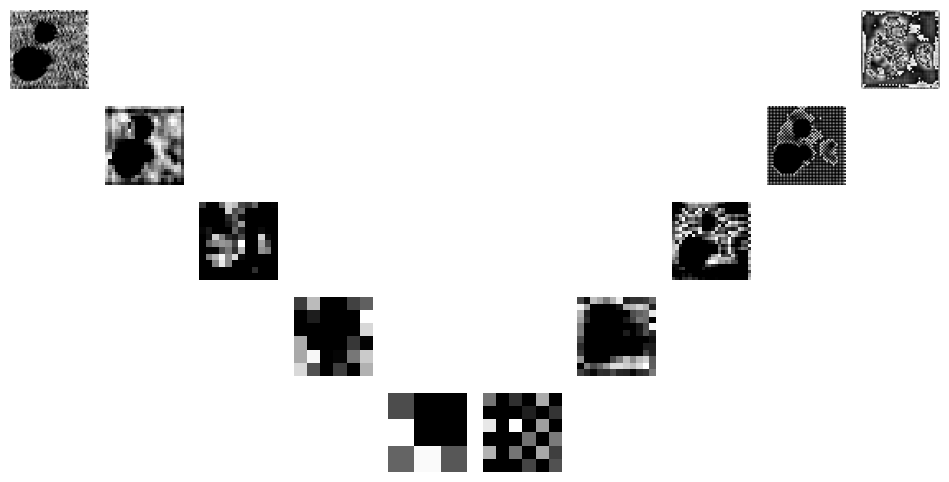

In [52]:
from PIL import Image

fig, axs = plt.subplots(5, 10, figsize=(12, 6))

for i in range(10):
    img_tensor = hidden_outputs[i][0]
    img = img_tensor[0].detach().numpy()
    img = Image.fromarray((img * 255).astype('uint8')) 
    
    x = i
    y = i if i < 5 else 9 - i
    axs[y][x].imshow(img, cmap='gray')
    
for ax in axs.flat:
    ax.axis('off')

plt.show()

### Итого

Реализована модель UNet архитектуры для сегментации объектов на изображениях. 

На слабой машине использовал совсем небольшие изображения. Хорошо заметен один из плюсов архитектуры UNet - достаточно совсем небольшой выборки для достижения достаточно хороших результатов. И, как одно из следствий этого, модель быстро обучается. Это характерно и для более сложных датасетов.